In [ ]:
from google.colab import files
files.upload()
!pip install -q kaggle
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json
!mkdir emotions
%cd emotions

Saving kaggle.json to kaggle.json
/content/emotions


In [ ]:
!kaggle datasets list -s Memotion-Dataset-7k

ref                                  title                 size  lastUpdated          downloadCount  voteCount  usabilityRating  
-----------------------------------  -------------------  -----  -------------------  -------------  ---------  ---------------  
williamscott701/memotion-dataset-7k  Memotion Dataset 7k  695MB  2020-02-27 13:06:01           2984         68  0.7647059        


In [ ]:
!kaggle datasets download williamscott701/memotion-dataset-7k

 97% 673M/695M [00:06<00:00, 151MB/s]
100% 695M/695M [00:06<00:00, 118MB/s]


In [ ]:
!unzip memotion-dataset-7k.zip

In [ ]:
import re
import string
import numpy as np
import pandas as pd
from tqdm import tqdm
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score
import os

import tensorflow as tf
from tensorflow.keras import Sequential, Model
from tensorflow.keras.layers import Conv2D, MaxPool2D, GlobalAveragePooling2D
from tensorflow.keras.layers import Dense, Flatten, BatchNormalization, Activation, Dropout
from tensorflow.keras.layers import Conv1D, Embedding, GlobalAveragePooling1D 
from tensorflow.keras.optimizers import Adam, RMSprop
from tensorflow.keras.preprocessing import image
from PIL import ImageFile,Image
from sklearn.preprocessing import LabelEncoder
ImageFile.LOAD_TRUNCATED_IMAGES = True

In [ ]:
df=pd.read_csv('/content/emotions/memotion_dataset_7k/labels.csv')
df.head()

,Unnamed: 0,image_name,text_ocr,text_corrected,humour,sarcasm,offensive,motivational,overall_sentiment
0,0,image_1.jpg,LOOK THERE MY FRIEND LIGHTYEAR NOW ALL SOHALIK...,LOOK THERE MY FRIEND LIGHTYEAR NOW ALL SOHALIK...,hilarious,general,not_offensive,not_motivational,very_positive
1,1,image_2.jpeg,The best of #10 YearChallenge! Completed in le...,The best of #10 YearChallenge! Completed in le...,not_funny,general,not_offensive,motivational,very_positive
2,2,image_3.JPG,Sam Thorne @Strippin ( Follow Follow Saw every...,Sam Thorne @Strippin ( Follow Follow Saw every...,very_funny,not_sarcastic,not_offensive,not_motivational,positive
3,3,image_4.png,10 Year Challenge - Sweet Dee Edition,10 Year Challenge - Sweet Dee Edition,very_funny,twisted_meaning,very_offensive,motivational,positive
4,4,image_5.png,10 YEAR CHALLENGE WITH NO FILTER 47 Hilarious ...,10 YEAR CHALLENGE WITH NO FILTER 47 Hilarious ...,hilarious,very_twisted,very_offensive,not_motivational,neutral


In [ ]:
df.drop(df.filter(regex='Unnamed', axis=1), inplace=True, axis=1)
df.drop(columns=['text_ocr', 'overall_sentiment'], inplace=True)
df.head()

,image_name,text_corrected,humour,sarcasm,offensive,motivational
0,image_1.jpg,LOOK THERE MY FRIEND LIGHTYEAR NOW ALL SOHALIK...,hilarious,general,not_offensive,not_motivational
1,image_2.jpeg,The best of #10 YearChallenge! Completed in le...,not_funny,general,not_offensive,motivational
2,image_3.JPG,Sam Thorne @Strippin ( Follow Follow Saw every...,very_funny,not_sarcastic,not_offensive,not_motivational
3,image_4.png,10 Year Challenge - Sweet Dee Edition,very_funny,twisted_meaning,very_offensive,motivational
4,image_5.png,10 YEAR CHALLENGE WITH NO FILTER 47 Hilarious ...,hilarious,very_twisted,very_offensive,not_motivational


In [ ]:
le = LabelEncoder()
humour=le.fit_transform(df['humour'])
a = dict(zip(le.classes_, le.transform(le.classes_)))
sarcasm=le.fit_transform(df['sarcasm'])
b = dict(zip(le.classes_, le.transform(le.classes_)))
offensive=le.fit_transform(df['offensive'])
c = dict(zip(le.classes_, le.transform(le.classes_)))
motivational=le.fit_transform(df['motivational'])
d = dict(zip(le.classes_, le.transform(le.classes_)))
df.drop("humour", axis=1, inplace=True)
df.drop("sarcasm", axis=1, inplace=True)
df.drop("offensive", axis=1, inplace=True)
df.drop("motivational", axis=1, inplace=True)

df["humour"] = humour
df["sarcasm"] = sarcasm
df["offensive"] = offensive
df["motivational"] = motivational

a,b,c,d

({'funny': 0, 'hilarious': 1, 'not_funny': 2, 'very_funny': 3},
 {'general': 0, 'not_sarcastic': 1, 'twisted_meaning': 2, 'very_twisted': 3},
 {'hateful_offensive': 0,
  'not_offensive': 1,
  'slight': 2,
  'very_offensive': 3},
 {'motivational': 0, 'not_motivational': 1})

In [ ]:
df.dropna(inplace=True)
df.isnull().any()

image_name        False
text_corrected    False
humour            False
sarcasm           False
offensive         False
motivational      False
dtype: bool

# Data Prep

In [ ]:
# rows_to_drop = ['image_120.jpg',
#               'image_4800.jpg',
#               'image_6782.jpg',
#               'image_6785.jpg',
#               'image_6787.jpg',
#               'image_6988.jpg',
#               'image_6989.jpg',
#               'image_6990.png',
#               'image_6991.jpg',
#               'image_6992.jpg']

In [ ]:
# for images in rows_to_drop:
#     df.drop(df[df['image_name'] == images].index, inplace=True)

In [ ]:
widhth=100
height=100

X=[]

image_folder='/content/emotions/memotion_dataset_7k/images'
for image in tqdm(df['image_name']):
  path=os.path.join(image_folder,image)
  img=Image.open(path).convert('RGB').resize((widhth,height))
  img=np.array(img)/255.0
  X.append(img)

X=np.array(X)

 96%|█████████▌| 6674/6987 [01:12<00:03, 80.66it/s]/usr/local/lib/python3.9/dist-packages/PIL/Image.py:975: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
100%|██████████| 6987/6987 [01:15<00:00, 92.16it/s]


In [ ]:


X[0].shape

(100, 100, 3)

In [ ]:
y=df.iloc[:,2:]
y.humour

0       1
1       2
2       3
3       3
4       1
       ..
6987    3
6988    0
6989    0
6990    2
6991    2
Name: humour, Length: 6987, dtype: int64

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2,shuffle=True)

# Image Preprocessing

In [ ]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers.experimental.preprocessing import RandomFlip,RandomZoom,RandomContrast,RandomRotation,Rescaling
from tensorflow.keras.applications.resnet_v2 import preprocess_input

data_augmentation=Sequential([
    RandomFlip(mode='horizontal'),
    RandomContrast([.5,2]),
    RandomRotation(factor=0.2),
    RandomZoom(height_factor=0.1, width_factor=0.1)
])
rescale=Rescaling(scale=1./127.5,offset=-1)

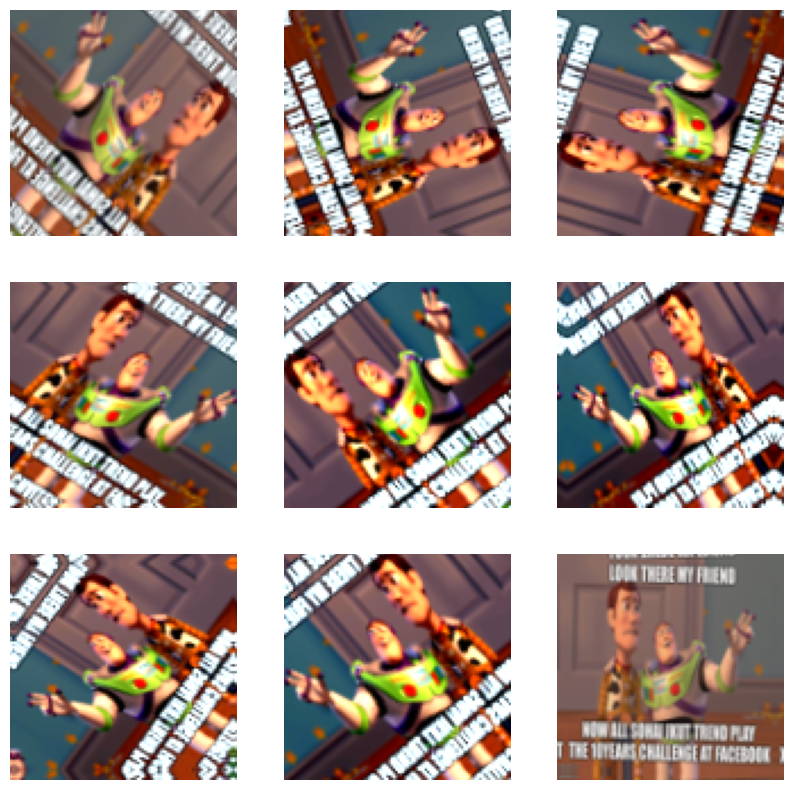

In [ ]:
plt.figure(figsize=(10, 10))
for i in range(9):
  augmented_image = data_augmentation(X)
  ax = plt.subplot(3, 3, i + 1)
  plt.imshow(augmented_image[0])
  plt.axis("off")

# Model for Image

In [ ]:
from tensorflow.keras.layers import Concatenate

In [ ]:
def image_model():
    model_1=tf.keras.applications.ResNet50(input_shape=X[0].shape,
                                       include_top=False,
                                       weights='imagenet')
    model_2=tf.keras.applications.VGG16(input_shape=X[0].shape,
                                   include_top=False,
                                   weights='imagenet')
    for base_model in [model_1,model_2]:
      base_model.trainable=False


    inputs=tf.keras.Input(shape=X[0].shape,name = 'image_input')
    x=data_augmentation(inputs)
    x=preprocess_input(x)
    x1=model_1(x)
    x1=Dropout(0.2)(x1)
    x1=Conv2D(2048,kernel_size=2,padding='valid')(x1)
    x1=Dropout(0.3)(x1) 
    x1=Dense(512)(x1)
    x1=Dropout(0.5)(x1)
    x2 = model_2(x)
    x2 = Dropout(0.4)(x2)
    x2 = Dense(512)(x2)
    x2 = Dropout(0.2)(x2)
    x=Concatenate()([x1,x2])
    x=Dropout(0.3)(x)
    x = GlobalAveragePooling2D()(x)
    x = Dropout(0.5)(x)
    return inputs,x

image_input,image_layers=image_model()

# Text Modelling

In [ ]:
def standardization(data):
    data = data.apply(lambda x: x.lower())
    data = data.apply(lambda x: re.sub(r'\d+', '', x))
    data = data.apply(lambda x: re.sub(r'\w*.com\w*', '', x, flags=re.MULTILINE))
    data = data.apply(lambda x: x.translate(str.maketrans('', '', string.punctuation)))
    return data

df['text_corrected'] = standardization(df.text_corrected)


In [ ]:
df['text_corrected'].head()

0    look there my friend lightyear now all sohalik...
1    the best of  yearchallenge in less the  years ...
2    sam thorne strippin  follow follow saw everyon...
3                    year challenge  sweet dee edition
4     year challenge with no filter  hilarious  yea...
Name: text_corrected, dtype: object

# Vectorizing Layers

In [ ]:
!pip install tensorflow_text
import tensorflow_hub as hub
import tensorflow_text as text

bert_preprocess = hub.KerasLayer("https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3")
bert_encoder = hub.KerasLayer("https://tfhub.dev/tensorflow/bert_en_uncased_L-12_H-768_A-12/4")
# from tensorflow.keras.layers.experimental.preprocessing import TextVectorization
# vocab_size = 100000
# sequence_length = 100

# vectorize_layer = TextVectorization(
#     max_tokens=vocab_size,
#     output_mode='int',
#     output_sequence_length=sequence_length)

# text_ds = np.asarray(df['text_corrected'])
# vectorize_layer.adapt(tf.convert_to_tensor(text_ds))


Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
# from tensorflow.keras.layers.experimental.preprocessing import TextVectorization

vocab_size = 10000
sequence_length = 200

# vectorize_layer = TextVectorization(
#     max_tokens=vocab_size,
#     output_mode='int',
#     output_sequence_length=sequence_length)

# text_ds = np.asarray(df['text_corrected'])
# vectorize_layer.adapt(text_ds)
# vectorize_text=vectorize_layer(df.text_corrected)
# vectorize_text


In [ ]:
X_text = df.text_corrected
X_text

0       look there my friend lightyear now all sohalik...
1       the best of  yearchallenge in less the  years ...
2       sam thorne strippin  follow follow saw everyon...
3                       year challenge  sweet dee edition
4        year challenge with no filter  hilarious  yea...
                              ...                        
6987    tuesday is mardi gras wednesday is valentines ...
6988    must watch movies of  iti chennai memes maanag...
6989    less more talking planning soda junk  worrying...
6990    when i have time is a fantasy no one has time ...
6991    the starting point for every good idea is what...
Name: text_corrected, Length: 6987, dtype: object

In [ ]:
X_text_train, X_text_test, y_text_train, y_text_test = train_test_split(X_text, y, test_size = 0.2,shuffle=True)

In [ ]:
from keras.layers import Input
embedding_dim=32





# embedding_dim=32

def text_model():
    text_input = Input(shape=(),dtype=tf.string, name='text')
    preprocessed_text = bert_preprocess(text_input)
    outputs = bert_encoder(preprocessed_text)
    text_layers = tf.keras.layers.Embedding(vocab_size, embedding_dim, name="embedding")(outputs['pooled_output'])
    dropout_layer = Dropout(0.3)(text_layers)
        
    text_layers = tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(512, activation='relu', return_sequences=True))(text_layers)
    dropout_layer = Dropout(0.4)(text_layers)
    text_layers = tf.keras.layers.BatchNormalization()(text_layers)

    text_layers = tf.keras.layers.Conv1D(128, 7, padding="valid", activation="relu", strides=3)(text_layers)
    dropout_layer = Dropout(0.2)(text_layers)
    text_layers = tf.keras.layers.GlobalMaxPooling1D()(text_layers)
    dropout_layer = Dropout(0.5)(text_layers)
        
    text_layers = tf.keras.layers.Dense(2048, activation="relu")(text_layers)
    text_layers = tf.keras.layers.Dropout(0.2)(text_layers)
    text_layers = tf.keras.layers.Dropout(0.1,)(outputs['pooled_output'])
    return text_input,text_layers

text_input, text_layers = text_model()



# Combining and Evaluating

In [ ]:
def model(layer_1,layer_2,image_input,text_input):
  concatenate=tf.keras.layers.concatenate([layer_1,layer_2],axis=1)
  semi_final_layer = tf.keras.layers.Dense(2048, activation='relu')(concatenate)

  prediction_layer_1 = tf.keras.layers.Dense(4,activation='softmax',name = 'humuor')
  prediction_layer_2 = tf.keras.layers.Dense(4, activation='softmax', name = 'sarcasm')
  prediction_layer_3 = tf.keras.layers.Dense(4, activation='softmax', name = 'offensive')
  prediction_layer_4 = tf.keras.layers.Dense(2, activation='softmax', name = 'motivational')

  output_1 = prediction_layer_1(semi_final_layer)
  output_2 = prediction_layer_2(semi_final_layer)
  output_3 = prediction_layer_3(semi_final_layer)
  output_4 = prediction_layer_4(semi_final_layer)

  model = tf.keras.Model(inputs = [image_input, text_input] , outputs = [output_1, output_2, output_3, output_4])
  return model

In [ ]:
# def model1(layer_1,Image_input):
#   model = Sequential()
#   semi_final_layer = tf.keras.layers.Dense(2048, activation='relu')(layer_1)

#   prediction_layer_1 = tf.keras.layers.Dense(4,activation='softmax',name = 'humuor')
#   prediction_layer_2 = tf.keras.layers.Dense(4, activation='softmax', name = 'sarcasm')
#   prediction_layer_3 = tf.keras.layers.Dense(4, activation='softmax', name = 'offensive')
#   prediction_layer_4 = tf.keras.layers.Dense(2, activation='softmax', name = 'motivational')

#   output_1 = prediction_layer_1(semi_final_layer)
#   output_2 = prediction_layer_2(semi_final_layer)
#   output_3 = prediction_layer_3(semi_final_layer)
#   output_4 = prediction_layer_4(semi_final_layer)

#   model = tf.keras.Model(inputs = image_input , outputs = [output_1, output_2, output_3, output_4])
#   return model

In [ ]:
model = model(image_layers,text_layers, image_input,text_input)
# model = model1(text_layers, text_input)
# !pip install transformers requests beautifulsoup4 pandas numpy

In [ ]:
# import os
# # Define the checkpoint directory to store the checkpoints
# checkpoint_dir = './training_checkpoints'

# # Name of the checkpoint files
# checkpoint_prefix = os.path.join(checkpoint_dir, "ckpt_{epoch}")

In [ ]:
def decay(epoch):
  if epoch < 5:
    return 1e-3
  elif epoch >= 5 and epoch < 15:
    return 1e-4
  else:
    return 1e-5

In [ ]:
# class PrintLR(tf.keras.callbacks.Callback):
#   def on_epoch_end(self, epoch, logs=None):
#     print('\nLearning rate for epoch {} is {}'.format(epoch + 1,
#                                                       model.optimizer.lr.numpy()))

# callbacks = [
#     tf.keras.callbacks.TensorBoard(log_dir='./logs'),
#     tf.keras.callbacks.ModelCheckpoint(filepath=checkpoint_prefix,
#                                        save_weights_only=True),
#     tf.keras.callbacks.LearningRateScheduler(decay),
#     PrintLR()
# ]

In [ ]:
base_learning_rate = 0.0001
losses = {
      "humuor": "sparse_categorical_crossentropy", 
      "sarcasm": "sparse_categorical_crossentropy", 
      "offensive": "sparse_categorical_crossentropy", 
      "motivational": "sparse_categorical_crossentropy"
}
lossWeights = {
      "humuor": 1.0, 
      "sarcasm": 1.0, 
      "offensive": 1.0, 
      "motivational": 1.0
}
metrics = {
      "humuor": "sparse_categorical_accuracy", 
      "sarcasm": "sparse_categorical_accuracy", 
      "offensive": "sparse_categorical_accuracy", 
      "motivational": "sparse_categorical_accuracy"
}
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=base_learning_rate),
              loss = losses,
              loss_weights= lossWeights,
              metrics=metrics)

In [ ]:
from tensorflow.keras.callbacks import EarlyStopping, TensorBoard, ModelCheckpoint


from tensorflow.keras.callbacks import EarlyStopping, TensorBoard, ModelCheckpoint

# # Define early stopping callback
# early_stopping = EarlyStopping(
#     monitor='val_loss', 
#     patience=3, # number of epochs to wait before stopping
#     restore_best_weights=True
)

# Define tensorboard callback
# tensorboard = TensorBoard(log_dir='./logs')

# Define model checkpoint callback
# checkpoint_prefix = "./checkpoints/checkpoint"
# model_checkpoint = ModelCheckpoint(
#     filepath=checkpoint_prefix,
#     save_weights_only=True,
# )

# Train the model
history = model.fit(
    x=[X_train,X_text_train],
    y=[ y_train.sarcasm, 
        y_train.humour, 
        y_train.offensive, 
        y_train.motivational],
    batch_size=16,
    epochs=30,
    validation_data=([X_test,X_text_test], 
                     [ y_test.sarcasm, 
                       y_test.humour, 
                       y_test.offensive, 
                       y_test.motivational]),
    # callbacks=[early_stopping, tensorboard, model_checkpoint]
)

Epoch 1/30
350/350 [==============================] - 95s 272ms/step - loss: 4.9078 - humuor_loss: 1.3429 - sarcasm_loss: 1.4806 - offensive_loss: 1.3388 - motivational_loss: 0.7455 - humuor_sparse_categorical_accuracy: 0.4278 - sarcasm_sparse_categorical_accuracy: 0.3160 - offensive_sparse_categorical_accuracy: 0.3589 - motivational_sparse_categorical_accuracy: 0.5851 - val_loss: 4.4385 - val_humuor_loss: 1.2353 - val_sarcasm_loss: 1.2948 - val_offensive_loss: 1.2418 - val_motivational_loss: 0.6666 - val_humuor_sparse_categorical_accuracy: 0.4814 - val_sarcasm_sparse_categorical_accuracy: 0.3569 - val_offensive_sparse_categorical_accuracy: 0.3684 - val_motivational_sparse_categorical_accuracy: 0.6488
Epoch 2/30
350/350 [==============================] - 95s 273ms/step - loss: 4.6034 - humuor_loss: 1.2616 - sarcasm_loss: 1.3881 - offensive_loss: 1.2508 - motivational_loss: 0.7029 - humuor_sparse_categorical_accuracy: 0.4564 - sarcasm_sparse_categorical_accuracy: 0.3224 - offensive_spar

In [ ]:
model.summary()

Model: "model_4"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 image_input (InputLayer)       [(None, 100, 100, 3  0           []                               
                                )]                                                                
                                                                                                  
 sequential (Sequential)        (None, 100, 100, 3)  0           ['image_input[0][0]']            
                                                                                                  
 tf.math.truediv_3 (TFOpLambda)  (None, 100, 100, 3)  0          ['sequential[3][0]']             
                                                                                                  
 tf.math.subtract_3 (TFOpLambda  (None, 100, 100, 3)  0          ['tf.math.truediv_3[0][0]']

In [ ]:
df_history = pd.DataFrame(history.history)
df_history

,loss,humuor_loss,sarcasm_loss,offensive_loss,motivational_loss,humuor_sparse_categorical_accuracy,sarcasm_sparse_categorical_accuracy,offensive_sparse_categorical_accuracy,motivational_sparse_categorical_accuracy,val_loss,val_humuor_loss,val_sarcasm_loss,val_offensive_loss,val_motivational_loss,val_humuor_sparse_categorical_accuracy,val_sarcasm_sparse_categorical_accuracy,val_offensive_sparse_categorical_accuracy,val_motivational_sparse_categorical_accuracy
0,4.907766,1.342874,1.480606,1.338789,0.745497,0.427805,0.315978,0.358919,0.585078,4.438511,1.235290,1.294796,1.241790,0.666634,0.481402,0.356938,0.368383,0.648784
1,4.603365,1.261559,1.388088,1.250778,0.702939,0.456432,0.322419,0.369476,0.602254,4.418214,1.235707,1.306933,1.229796,0.645777,0.481402,0.331903,0.299714,0.652360
2,4.518981,1.235071,1.362425,1.234677,0.686808,0.470209,0.320988,0.375559,0.606012,4.477890,1.224243,1.331977,1.215423,0.706246,0.481402,0.314020,0.369814,0.359084
3,4.462600,1.218194,1.349330,1.215193,0.679883,0.477008,0.326892,0.377706,0.614242,4.395518,1.230902,1.312545,1.202383,0.649688,0.481402,0.324750,0.366237,0.652360
4,4.408759,1.204570,1.328743,1.206494,0.668952,0.492575,0.338343,0.383074,0.633566,4.384678,1.209800,1.316241,1.202971,0.655666,0.481402,0.351931,0.379828,0.650930
5,4.384884,1.198229,1.320050,1.200376,0.666228,0.497227,0.329397,0.373770,0.628198,4.381974,1.224274,1.297173,1.212072,0.648455,0.480687,0.351216,0.379828,0.652360
6,4.362220,1.191959,1.315001,1.194675,0.660586,0.505278,0.334586,0.365539,0.637681,4.383513,1.217008,1.305002,1.202506,0.658997,0.481402,0.329041,0.379828,0.652360
7,4.353769,1.189375,1.315731,1.190325,0.658337,0.502237,0.342816,0.382358,0.641975,4.333684,1.192057,1.311687,1.183433,0.646507,0.481402,0.314020,0.379828,0.652360
8,4.338782,1.187735,1.311350,1.181802,0.657897,0.502415,0.343711,0.382716,0.643407,4.328433,1.193901,1.300745,1.184406,0.649381,0.481402,0.314020,0.380544,0.652360
9,4.327558,1.185442,1.302463,1.183986,0.655667,0.505636,0.337627,0.373412,0.643228,4.326181,1.195496,1.299239,1.184414,0.647033,0.481402,0.351216,0.380544,0.652360


In [ ]:
df_history.columns

Index(['loss', 'humuor_loss', 'sarcasm_loss', 'offensive_loss',
       'motivational_loss', 'humuor_sparse_categorical_accuracy',
       'sarcasm_sparse_categorical_accuracy',
       'offensive_sparse_categorical_accuracy',
       'motivational_sparse_categorical_accuracy', 'val_loss',
       'val_humuor_loss', 'val_sarcasm_loss', 'val_offensive_loss',
       'val_motivational_loss', 'val_humuor_sparse_categorical_accuracy',
       'val_sarcasm_sparse_categorical_accuracy',
       'val_offensive_sparse_categorical_accuracy',
       'val_motivational_sparse_categorical_accuracy'],
      dtype='object')

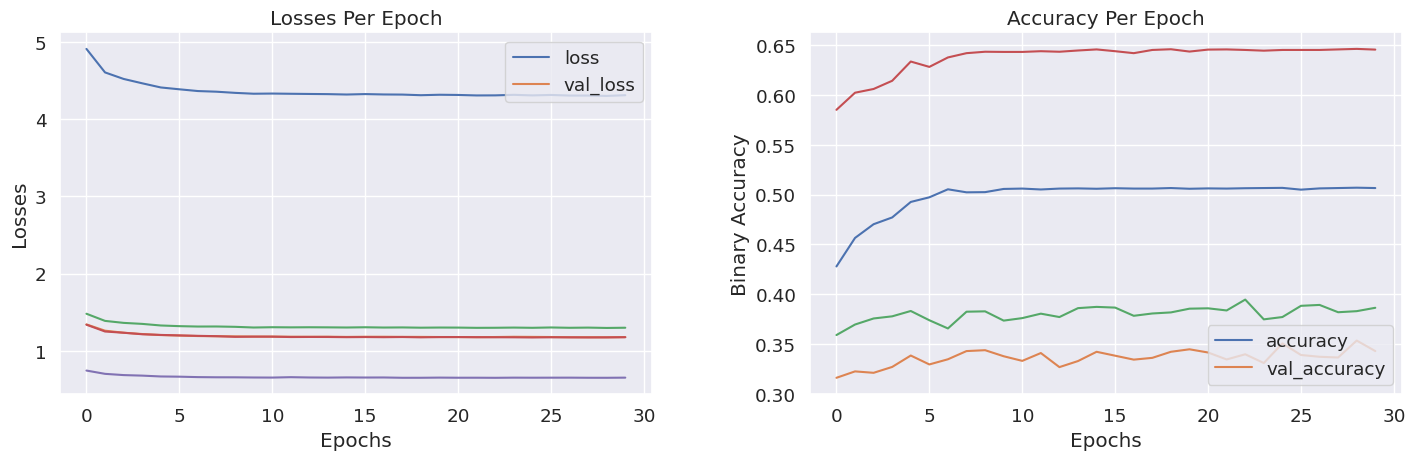

In [ ]:
import seaborn as sns
sns.set(font_scale=1.2)
fig, axes = plt.subplots(1,2, figsize=(16, 6))
fig.tight_layout(pad=5.0)

axes[0].plot(df_history.loss)
axes[0].plot(df_history.humuor_loss)
axes[0].plot(df_history.sarcasm_loss)
axes[0].plot(df_history.offensive_loss)
axes[0].plot(df_history.motivational_loss)
axes[0].set_xlabel('Epochs')
axes[0].set_ylabel('Losses')
axes[0].set_title('Losses Per Epoch')
axes[0].legend(['loss', 'val_loss'], loc='upper right')

axes[1].plot(df_history.humuor_sparse_categorical_accuracy)
axes[1].plot(df_history.sarcasm_sparse_categorical_accuracy)
axes[1].plot(df_history.offensive_sparse_categorical_accuracy)
axes[1].plot(df_history.motivational_sparse_categorical_accuracy)
axes[1].set_xlabel('Epochs')
axes[1].set_ylabel('Binary Accuracy')
axes[1].set_title('Accuracy Per Epoch')
axes[1].legend(['accuracy', 'val_accuracy'], loc='lower right')

plt.show()

In [ ]:
X_text_test.shape

(1398,)

In [ ]:
from sklearn.metrics import accuracy_score
y_pred = model.predict([ X_test, X_text_test])

# Extract individual predictions for each task
y_sarcasm_pred, y_humuor_pred, y_offensive_pred, y_motivational_pred = y_pred

# Convert softmax output to class predictions
y_sarcasm_pred_classes = np.argmax(y_sarcasm_pred, axis=1)
y_humuor_pred_classes = np.argmax(y_humuor_pred, axis=1)
y_offensive_pred_classes = np.argmax(y_offensive_pred, axis=1)
y_motivational_pred_classes = np.argmax(y_motivational_pred, axis=1)

# Calculate evaluation metrics
sarcasm_acc = accuracy_score(y_test.sarcasm, y_sarcasm_pred_classes)
humuor_acc = accuracy_score(y_test.humour, y_humuor_pred_classes)
offensive_acc = accuracy_score(y_test.offensive, y_offensive_pred_classes)
motivational_acc = accuracy_score(y_test.motivational, y_motivational_pred_classes)


# Print evaluation metrics
print("Sarcasm Accuracy:", sarcasm_acc)
print("Humuor Accuracy:", humuor_acc)
print("Offensive Accuracy:", offensive_acc)
print("Motivational Accuracy:", motivational_acc)

44/44 [==============================] - 16s 376ms/step
Sarcasm Accuracy: 0.4814020028612303
Humuor Accuracy: 0.3512160228898426
Offensive Accuracy: 0.37052932761087265
Motivational Accuracy: 0.6523605150214592


In [ ]:
y_test.shape,len(y_pred)

((1398, 4), 4)

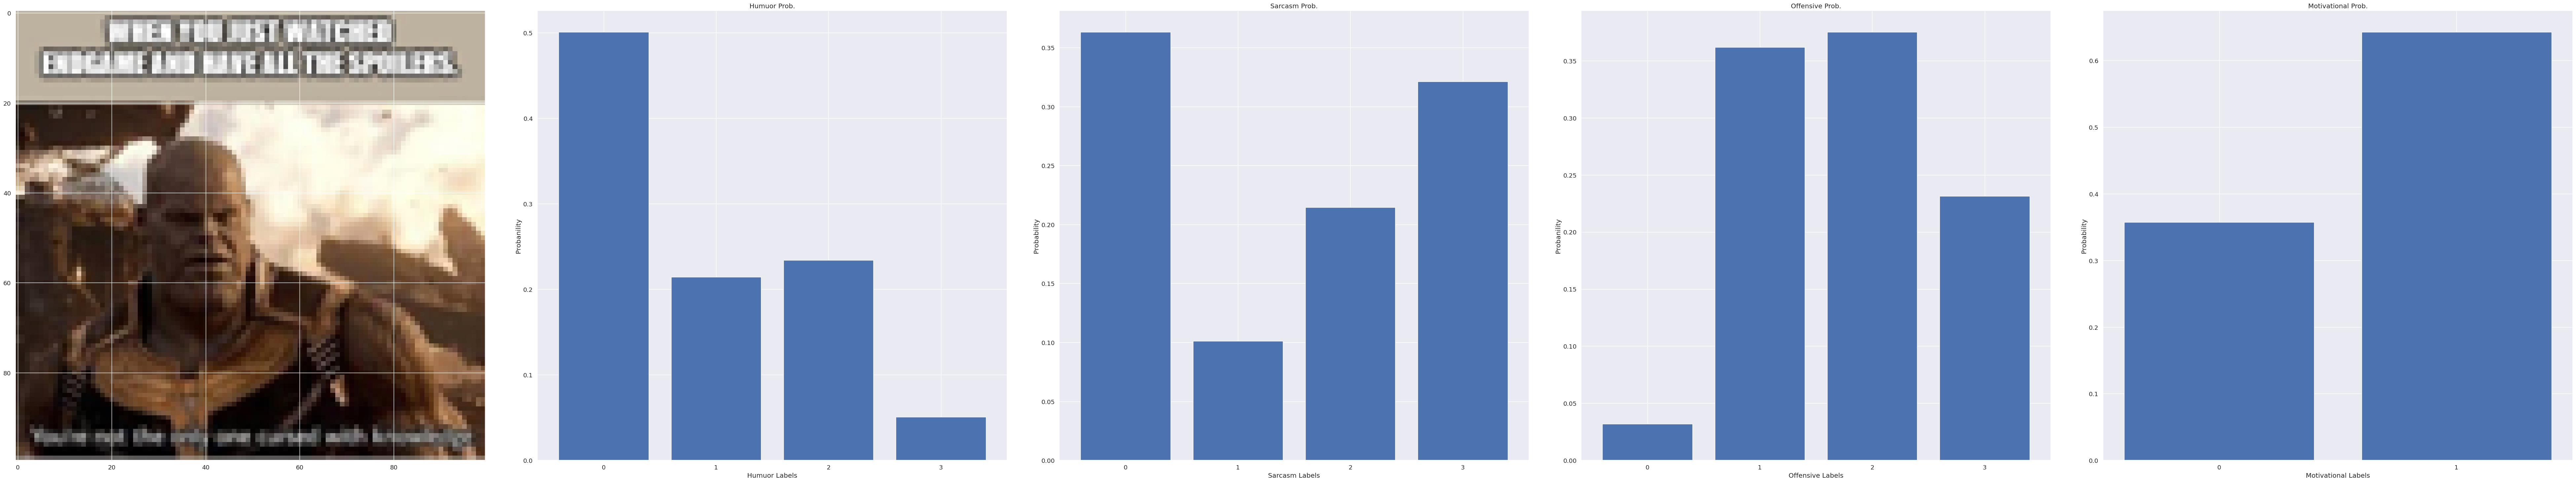

image_name                                             image_40.jpg
text_corrected    when you just watched endgame and have all the...
humour                                                            0
sarcasm                                                           0
offensive                                                         2
motivational                                                      0
Name: 39, dtype: object


({'funny': 0, 'hilarious': 1, 'not_funny': 2, 'very_funny': 3},
 {'general': 0, 'not_sarcastic': 1, 'twisted_meaning': 2, 'very_twisted': 3},
 {'hateful_offensive': 0,
  'not_offensive': 1,
  'slight': 2,
  'very_offensive': 3},
 {'motivational': 0, 'not_motivational': 1})

In [ ]:
fig, axes = plt.subplots(1,5, figsize=(80, 16))
fig.tight_layout(pad=5.0)


x = [0, 1, 2, 3]
im=39
axes[0].imshow(X[im,:,:,:], aspect='auto')

axes[1].bar(x, humuor_pred[im,:])
axes[1].set_xlabel('Humuor Labels')
axes[1].set_ylabel('Probanility')
axes[1].set_title('Humuor Prob.')
axes[1].set_xticks(x)

axes[2].bar(x, sarcasm_pred[im,:])
axes[2].set_xlabel('Sarcasm Labels')
axes[2].set_ylabel('Probability')
axes[2].set_title('Sarcasm Prob.')
axes[2].set_xticks(x)

axes[3].bar(x, offensive_pred[im,:])
axes[3].set_xlabel('Offensive Labels')
axes[3].set_ylabel('Probanility')
axes[3].set_title('Offensive Prob.')
axes[3].set_xticks(x)

axes[4].bar([0, 1], motivational_pred[im,:])
axes[4].set_xlabel('Motivational Labels')
axes[4].set_ylabel('Probability')
axes[4].set_title('Motivational Prob.')
axes[4].set_xticks([0, 1])
plt.show()

print(df.iloc[im,:])
a,b,c,d

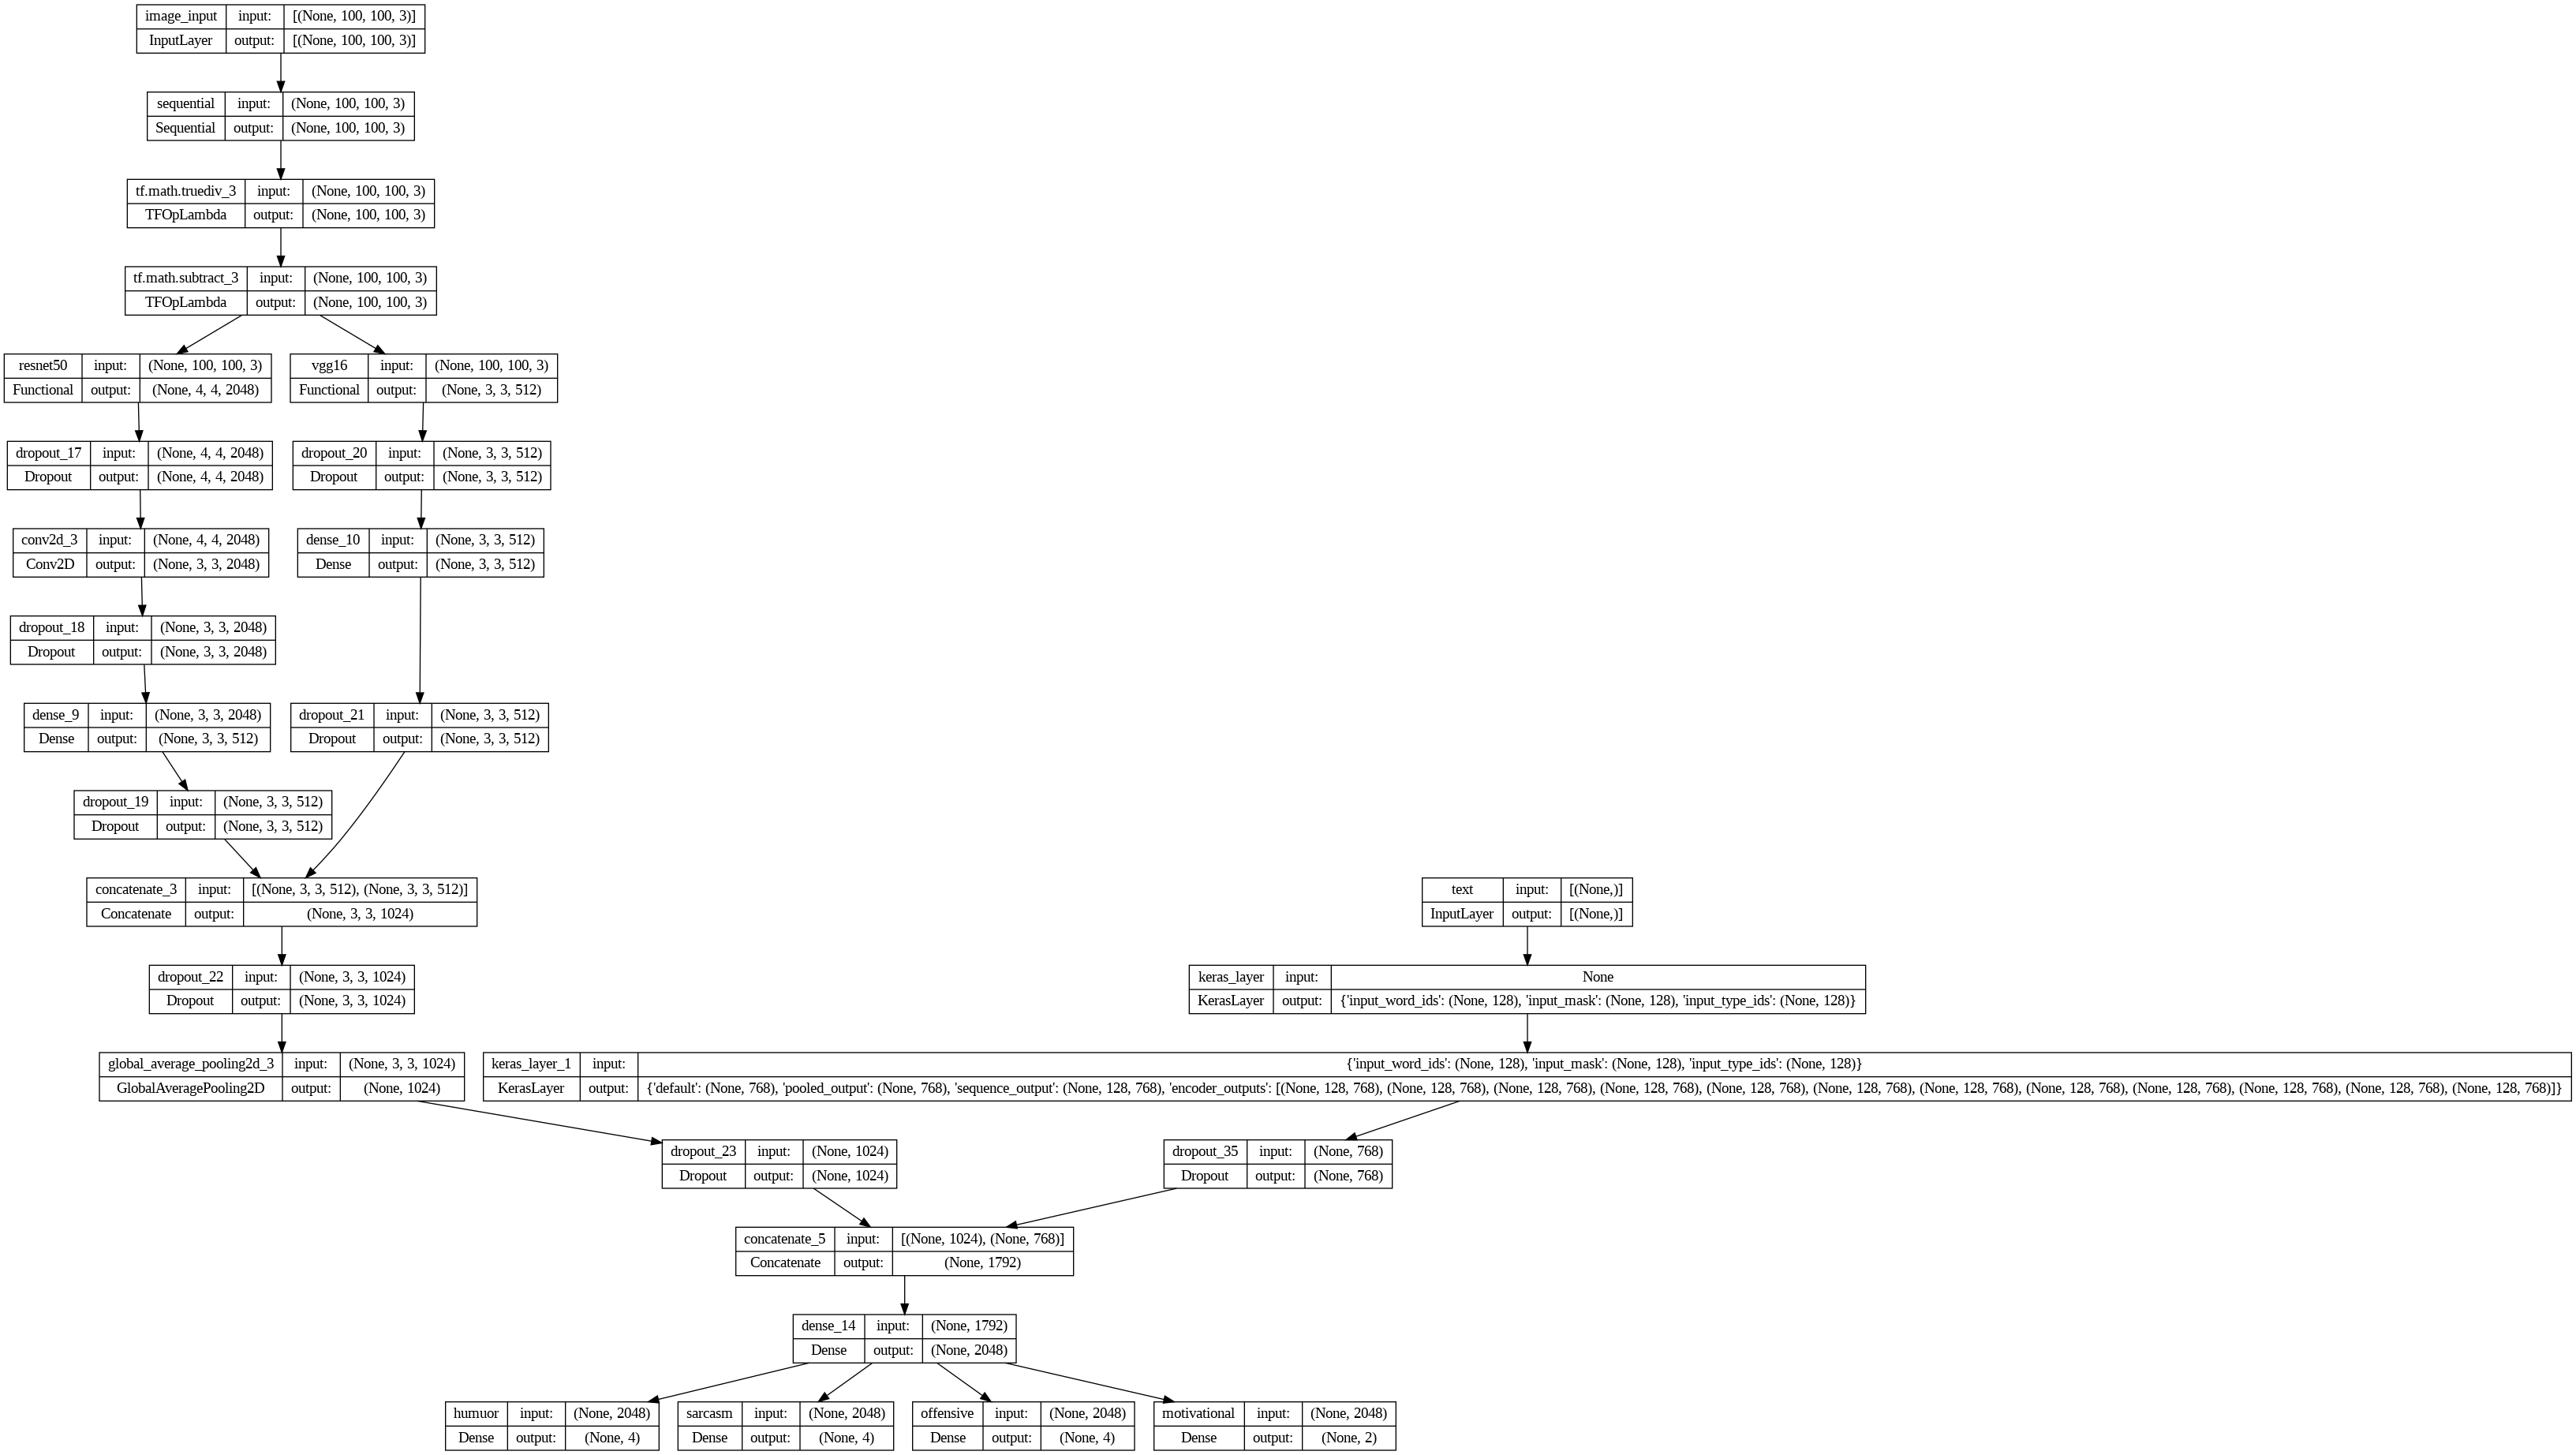

In [ ]:
tf.keras.utils.plot_model(model, "multi_input_and_output_model.png", show_shapes=True)